<a href="https://colab.research.google.com/github/arjangvt/CodeFolio/blob/main/ML/ObjectDetectionPipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here I developed a pipeline that user can easily change the model from
TensorFlow 2.0 Detection Model Zoo
To run this code: <br>

1- Mount the your Colab to the Google drive (The code is already there)<br> 
2- On your mounted drive create two subdirecotries called "pretrained_models" and "test". The first will contain all downloaded models and the second one woudld be an storage for your images.<br>
3- You need to have coco.names file as well.<br>
Note1: I included some test images and coco.names file in my Git repo for downloading.<br>
Note2: A better version of this code will chack a picture with all given model to find the best! <br>


<br> <br>

---





Written by: Arjang Fahim<br>
Date: 12/8/2021<br>
Last update: 12/8/2021<br>

In [1]:
import tensorflow as tf
import cv2, time, os
from google.colab import drive
import numpy as np
from tensorflow.python.keras.utils.data_utils import get_file
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)

2.8.0


In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
tf.config.list_logical_devices('GPU')

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [18]:
np.random.seed(20)

In [53]:
class Detector():
  def __init__(self):
    pass

  def readClasses(self, classesFilePath, cacheDir):
    with open(classesFilePath, 'r') as f:
      self.classesList = f.read().splitlines()
      self.cacheDir = cacheDir
      #colors list
      self.colorList = np.random.uniform(low=0, high=255, size=(len(self.classesList), 3))

      print(len(self.classesList), len(self.colorList))

  def downloadModel(self, modelURL):
     fileName = os.path.basename(modelURL)
     self.modelName = fileName[:fileName.index('.')]

     get_file(fname=fileName, origin=modelURL, cache_dir=self.cacheDir, cache_subdir="checkpoints", extract=True)

  def loadModel(self):
    print("Loading Model {}".format(self.modelName))

    tf.keras.backend.clear_session()
    self.model = tf.saved_model.load(os.path.join(self.cacheDir, "checkpoints", self.modelName, "saved_model"))

    print("Model {} loaded successfully ...".format(self.modelName))

  def createBoundingBox(self,image, threshold = 0.5):
    inputTensor = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
    inputTensor = tf.convert_to_tensor(inputTensor, dtype=tf.uint8)
    inputTensor = inputTensor[tf.newaxis, ...]

    detections = self.model(inputTensor)
    bboxes = detections['detection_boxes'][0].numpy()
    classIndexes = detections['detection_classes'][0].numpy().astype(np.int32)
    classScores = detections['detection_scores'][0].numpy()

    imH, imW, imC = image.shape

    bboxIdx = tf.image.non_max_suppression(bboxes, classScores, 
                                           max_output_size=50, 
                                           iou_threshold=threshold, score_threshold=threshold)

    print(bboxIdx)
    #if len(bboxes) != 0:
    if len(bboxIdx) != 0:
      #for i in range(0, len(bboxes)):
      for i in bboxIdx:
        bbox = tuple(bboxes[i].tolist())
        classConfidence = round(100 * classScores[i])
        classIndex = classIndexes[i]
        
        classLabelText = self.classesList[classIndex].upper()
        classColor = self.colorList[classIndex]

        displayText = '{}: {}%'.format(classLabelText, classConfidence)

        ymin, xmin, ymax, xmax = bbox

        xmin, xmax, ymin, ymax = (xmin * imW, xmax * imW, ymin*imH, ymax*imH)
        xmin, xmax, ymin, ymax = int(xmin), int(xmax), int(ymin), int(ymax)
        
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color=classColor, thickness=1)
        cv2.putText(image, displayText, (xmin, ymin -10), 
                    cv2.FONT_HERSHEY_PLAIN, 1, classColor, 2)
        
        linewidth = min(int((xmax-xmin)*0.2), int((ymax-ymin)*0.2))
        cv2.line(image, (xmin, ymin), (xmin+linewidth, ymin), classColor, thickness=5)
        cv2.line(image, (xmin, ymin), (xmin, ymin+linewidth), classColor, thickness=5)

        cv2.line(image, (xmax, ymin), (xmax-linewidth, ymin), classColor, thickness=5)
        cv2.line(image, (xmax, ymin), (xmax, ymin+linewidth), classColor, thickness=5)

        cv2.line(image, (xmin, ymax), (xmin+linewidth, ymax), classColor, thickness=5)
        cv2.line(image, (xmin, ymax), (xmin, ymax-linewidth), classColor, thickness=5)

        cv2.line(image, (xmax, ymax), (xmax-linewidth, ymax), classColor, thickness=5)
        cv2.line(image, (xmax, ymax), (xmax, ymax-linewidth), classColor, thickness=5)


    return image

  def predictImage(self, imagePath, threshold=0.5):
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    bboximage = self.createBoundingBox(image, threshold)
    plt.imshow(bboximage)
    plt.rcParams["figure.figsize"] = (20,20)
    plt.imshow(bboximage)
    plt.show()

In [57]:
# Customize these URLs
classFile = "Yourdir/coco.names"
#modelURL =  "http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_320x320_coco17_tpu-8.tar.gz"
#modelURL = "http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d4_coco17_tpu-32.tar.gz"
#modelURL = "http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz"
modelURL = "http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d7_coco17_tpu-32.tar.gz"
cacheDir = "Yourdir/pretrained_models"

imagePath = "Yourdir/test/5.jpg"

In [58]:
detector = Detector()
detector.readClasses(classFile, cacheDir)

detector.downloadModel(modelURL)
detector.loadModel()

92 92
394477568/394474998 [==============================] - 7s 0us/step
Loading Model efficientdet_d7_coco17_tpu-32


Model efficientdet_d7_coco17_tpu-32 loaded successfully ...


tf.Tensor([0 1 2], shape=(3,), dtype=int32)


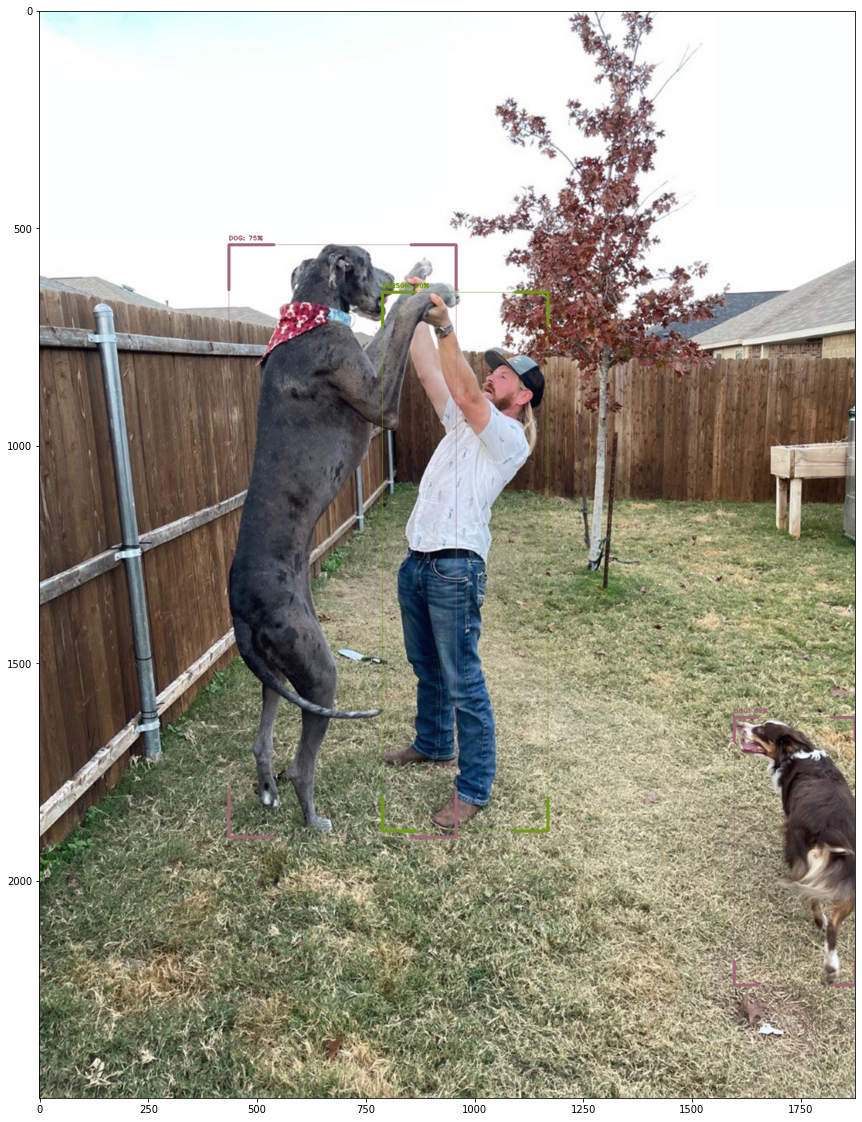

In [59]:
threshold = 0.5
detector.predictImage(imagePath, threshold)